## DEPENDENCIES

In [ ]:
!pip install scikit-surprise seaborn
!pip install pyspark
!pip install git+https://github.com/gbolmier/funk-svd

# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://www-us.apache.org/dist/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
# !tar xf spark-2.4.6-bin-hadoop2.7.tgz

     |████████████████████████████████| 11.8MB 6.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670955 sha256=d447403b170e7337bb9b072d04186a4676c5082cd0e64621940c5fa8967d3cf8
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
     |████████████████████████████████| 204.7MB 75kB/s 
     |████████████████████████████████| 204kB 51.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=5d2015ba2a2ff3a0b7f712aa24dcef7f3f0e010e45a0e4eb27ed4205e5898667
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark
  Cloning https://github.com/gbolmier/funk-svd to /tmp/pip-req-build-b3zc9cv6
  Running command git clone -q https://github.com/gbolmier/funk-svd /tmp/pip-req-build-b3zc9cv6
  Created wheel for funk-svd: filename=fu

In [ ]:
# spark
import os
import pyspark

# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"

# import findspark
# findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext.setCheckpointDir('/content/drive/My Drive/thesis/checkpoint/')

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import StructField, StructType, StringType, FloatType

# system
import sys
sys.path.append('/content/drive/My Drive/thesis')

# dataframe and plotting
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# surprise library
from surprise import Reader, Dataset, dump
from surprise.model_selection import train_test_split, cross_validate, KFold
from surprise.accuracy import rmse, mae

# source
from util.util import precision_recall_at_k

%matplotlib inline
pd.plotting.register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### CONSTANTS

In [ ]:
# constant for consistent evaluation

# the answer of the universe
SEED = 42

# number of recommendation products
N_REC = 50

# traint set ratio
TEST_SIZE = 0.2

# num data
NROWS = 1000000

# number of K to compute precision and recall @k
K = 20
KS = range(5, 15, 5)

# threshold of a rating to be considered "relevant"
THRESHOLD = 3.0

# drive path
DRIVE_PATH = 'drive/My Drive/thesis'

### RECOMMENDER WRAPPER CLASS

In [ ]:
import numpy as np
import sys
sys.path.append('/content/drive/My Drive/thesis')

from util.util import precision_recall_at_k

from surprise import SVD, dump
from surprise.utils import get_rng
from surprise.model_selection import cross_validate

from collections import defaultdict

def prak(predictions, k=10, threshold=3.0):
    """Return precision and recall at k metrics for each user."""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

class Recommender:
    def __init__(self, model_path):
        # load prediction and model from a given file
        self.predictions, self.model = dump.load(model_path)
        self.user_ratings = defaultdict(set)

    def recommend(self, raw_uid, k=50, exclude_test=False):
        recommendations = []
        # get all the items from saved trainset
        for iid in self.model.trainset.all_items():
          if exclude_test:
            # if user has rated the product, skip it
            uid = self.model.trainset.to_inner_uid(raw_uid)
            if uid in self.user_ratings and iid in self.user_ratings[uid]:
              continue

          rid = self.model.trainset.to_raw_iid(iid)
          prediction = self.model.predict(raw_uid, rid)

          # only consider rating that are larger or equal than 3
          #if prediction.est >= 3:
          recommendations.append((rid, prediction.est))

        recommendations.sort(key=lambda x: x[1], reverse=True)
        return recommendations[:k]

    def map_user_rating(self):
      for uid, ratings in self.model.trainset.ur.items():
        self.user_ratings[uid] = set([r[0] for r in ratings])

    def get_neighbors(self, raw_id, user_based=False, k=50):
      """Returns Top-K neighbors of a user of item.
      Args:
          raw_id: User/item raw id
          k: Number of neighbors
      """
      if user_based:
          to_inner = self.model.trainset.to_inner_uid
          to_raw = self.model.trainset.to_raw_uid
      else:
          to_inner = self.model.trainset.to_inner_iid
          to_raw = self.model.trainset.to_raw_iid

      inner_id = to_inner(raw_id)
      inner_neighbors = self.model.get_neighbors(inner_id, k=k)

      raw_neighbors = [to_raw(iid) for iid in inner_neighbors]
  
      return raw_neighbors

    def get_short_head_and_long_tail_items(self, threshold):
        """Returns the short head and long tail items as a tuple.
        Args:
            threshold (int): If user's number of ratings larger than the threshold, it is in short-head.
             Else, it is in long-tail.
        """
        # using set for faster look-up time
        short_head_items = set()
        long_tail_items = set()


        for inner_iid, ratings in self.model.trainset.ir.items():
            raw_iid = self.model.trainset.to_raw_iid(inner_iid)
            if len(ratings) >= threshold:
                short_head_items.add(raw_iid)
            else:
                long_tail_items.add(raw_iid)

        return short_head_items, long_tail_items

    def compute_precision_recall_at_k(self, k=20, threshold=3):
      precisions, recalls = prak(self.predictions, k=k, threshold=threshold)
      
      self.avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
      self.avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

      return self.avg_precision, self.avg_recall

    def compute_f1(self):
      return 2 * (self.avg_precision * self.avg_recall) / (self.avg_precision + self.avg_recall)

### NEW INCREMENTAL-SVD

In [ ]:
from funk_svd import SVD
from funk_svd.fast_methods import _run_epoch

class ISVD(SVD):
  def partial_fit(self, X):
    X = X.copy()

    u_ids = X['u_id'].unique().tolist()
    i_ids = X['i_id'].unique().tolist()

    n_user = len(self.user_dict)
    n_item = len(self.item_dict)
    n_new_user = 0
    n_new_item = 0

    for u_id in u_ids:
      if u_id not in self.user_dict:
        self.user_dict[u_id] = n_user
        n_user += 1
        n_new_user += 1

    for i_id in i_ids:
      if i_id not in self.item_dict:
        self.item_dict[i_id] = n_item
        n_item += 1
        n_new_item += 1

    X['u_id'] = X['u_id'].map(self.user_dict).astype(np.int32)
    X['i_id'] = X['i_id'].map(self.item_dict).astype(np.int32)

    # Start with the previous model
    pu = self.pu
    qi = self.qi
    bu = self.bu
    bi = self.bi

    X = X.values

    # Add rows for existed pu, qi, bu, bi
    pu_ = np.random.normal(0, .1, (n_new_user, self.n_factors))
    qi_ = np.random.normal(0, .1, (n_new_item, self.n_factors))
    bu_ = np.zeros(n_new_user)
    bi_ = np.zeros(n_new_item)

    pu = np.concatenate((pu, pu_))
    qi = np.concatenate((qi, qi_))
    bu = np.concatenate((bu, bu_))
    bi = np.concatenate((bi, bi_))

    # Run SGD for 1 epoch
    start = self._on_epoch_begin(0)
    pu, qi, bu, bi = _run_epoch(X, pu, qi, bu, bi, self.global_mean, self.n_factors, self.lr, self.reg)
    self._on_epoch_end(start)

    self.pu = pu
    self.qi = qi
    self.bu = bu
    self.bi = bi
    
import pickle 

def save_model(file_name, model=None, predictions=None, trainset=None):
  dump_obj = {
      'predictions': predictions,
      'model': model,
      'trainset': trainset,
  }
  pickle.dump(dump_obj, open(file_name, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

def load_model(file_name):
  dump_obj = pickle.load(open(file_name, 'rb'))
  return dump_obj['model'], dump_obj['predictions'], dump_obj['trainset']


from collections import defaultdict

class RecSys:
  def __init__(self, model_path):
    self.model, self.predictions, self.trainset = load_model(model_path)
    
  def recommend(self, u_id, n=50):
    # Get all train products
    all_items = self.trainset['i_id'].unique()
    # Predict the user rating on each product

    recommendations = []
    for i_id in all_items:
      prediction = self.model.predict_pair(u_id, i_id)
      recommendations.append((i_id, prediction))

    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:n]

  
  def get_top_n(self, n=10):
    # Get top n recommendation from test set
    top_n = defaultdict(list)
    for uid, iid, true_r, est in self.predictions.values:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

  def get_ideal_top_n(self, n=10):
    ideal_top_n = defaultdict(list)

    for raw_uid, raw_iid, overall, _ in self.predictions.values:
      ideal_top_n[raw_uid].append((raw_iid, overall))

    for raw_uid, user_ratings in ideal_top_n.items():
      user_ratings.sort(key=lambda x: x[1], reverse=True)
      ideal_top_n[raw_uid] = user_ratings[:n]

    return ideal_top_n
    
  def get_short_head_and_long_tail_items(self, threshold):
    """Returns the short head and long tail items as a tuple.
    Args:
        threshold (int): If user's number of ratings larger than the threshold, it is in short-head.
          Else, it is in long-tail.
    """
    # using set for faster look-up time
    train_items = self.trainset.groupby(by='i_id').count().reset_index()
    short_head_items = set(train_items[train_items['rating'] >= threshold]['i_id'].values)
    long_tail_items = set(train_items[train_items['rating'] < threshold]['i_id'].values)

    self.short_head = short_head_items
    self.long_tail = long_tail_items

    return short_head_items, long_tail_items

  def get_user_profile(self, u_id):
    return self.trainset[self.trainset['u_id'] == u_id]['i_id'].unique()

### PYSPARK HELPER FUNCTIONS

In [ ]:
def uid_to_ruid(df, uid):
  '''
  Convert user index to raw "reviewerID"
  '''
  user_row = df[df['reviewerID_index'].isin([uid])]

  if user_row.count():
    return user_row.collect()[0].reviewerID

  return False

def iid_to_riid(df, iid):
  '''
  Convert item index to "asin"
  '''
  item_row = df[df['asin_index'].isin([iid])]

  if item_row.count():
    return item_row.collect()[0].asin
  
  return False

def riid_to_iid(df, rid):
  item_row = df[df['asin'].isin([rid])] 

  if item_row.count():
    return item_row.collect()[0]['asin_index']

  return False

def ruid_to_uid(df, ruid):
  user_row = df[df['reviewerID'].isin([ruid])]

  if user_row.count():
    return user_row.collect()[0]['reviewerID_index']

  return False

def als_recommend(model, df, ruid, k=10):
  uid = ruid_to_uid(df, ruid)
  user_row = df.filter(df['reviewerID_index'] == uid).select('reviewerID_index').distinct()

  if user_row.count():
      rec_dict = model.recommendForUserSubset(user_row, k).collect()[0].asDict()['recommendations']
      rec_list = set()

      for rec in rec_dict:
        rec_list.add((iid_to_riid(df, rec[0]), rec[1]))
      
      return rec_list
      
  return False

def pyspark_precision_recall_at_k(predictions, k=10, threshold=3.0):
  precisions = dict()
  recalls = dict()

  for uid, user_ratings in predictions.items():
    # number of relevant items
    n_rel = sum((overall >= threshold) for (_, overall) in user_ratings)

    # number of recommended item in top K
    n_rec = sum((prediction >= threshold) for (prediction, _) in user_ratings[:k])

    # number of relevant and recommended in top K
    n_rel_and_rec = sum((overall >= threshold) and (prediction >= threshold) for (prediction, overall) in user_ratings[:k])

    # precision@k = proportion of recommended items that are relevant
    precisions[uid] = n_rel_and_rec / n_rec if n_rec != 0 else 0

    # recall@k = proportion of relevant items that are recommended
    recalls[uid] = n_rel_and_rec / n_rel if n_rel != 0 else 0

  als_precision = sum(prec for prec in precisions.values()) / len(precisions)
  als_recall = sum(rec for rec in recalls.values()) / len(recalls)
  als_f1 = 2 * (als_precision * als_recall) / (als_precision + als_recall)

  return als_precision, als_recall, als_f1

## DATA PRE-PROCESSING

### REMOVE NOISE 

In [ ]:
import pandas as pd
# Load data
ratings = pd.read_csv(DRIVE_PATH + '/data/ratings_score.csv', names=['user', 'item', 'overall', 'time'])
ratings.shape

(7824482, 4)

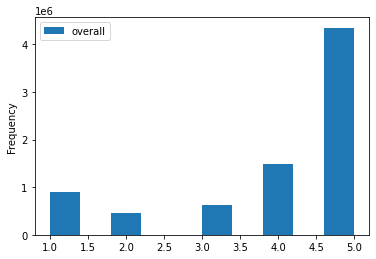

In [ ]:
ratings.drop(columns=['time'], axis=1, inplace=True)
ratings.plot(kind='hist')

In [ ]:
user_count = ratings.groupby('user').overall.count().reset_index().rename(columns={'overall': 'num_rating'})

In [ ]:
import numpy as np 
user_count.quantile(np.arange(0.9, 1, 0.01))

,num_rating
0.90,3.0
0.91,4.0
0.92,4.0
0.93,4.0
0.94,5.0
0.95,5.0
0.96,6.0
0.97,7.0
0.98,8.0
0.99,12.0


In [ ]:
def filter_noise(ratings, threshold=10):
  ratings_per_user = ratings.groupby('user').overall.count().reset_index().rename(columns={'overall': 'num_rating'})
  ratings_ = ratings.merge(ratings_per_user, on='user')
  cleaned_ratings = ratings_[ratings_.num_rating.astype('int') >= threshold]
  cleaned_ratings.drop(columns=['num_rating'], axis=1, inplace=True)

  return cleaned_ratings

In [ ]:
ratings_ = filter_noise(ratings, 50)
# ratings_.to_csv(DRIVE_PATH + '/data/final.csv', index=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


NUMBER OF USERS: 1540 (was 4201696) - a reduction of 99.963348133706%
NUMBER OF PRODUCTS: 48190 (was 476002) - a reduction of 89.87609295759262%
NUMBER OF RATINGS: 125871 (was 7824482)


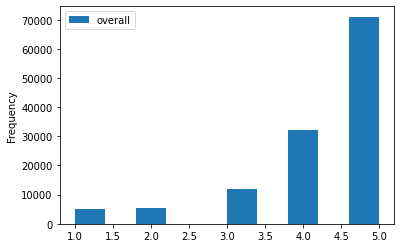

In [ ]:
n_users_before = ratings['user'].nunique()
n_products_before = ratings['item'].nunique()

n_users = ratings_['user'].nunique()
n_products = ratings_['item'].nunique()

users_reduction_percentage = 1 - (n_users / n_users_before)
products_reduction_percentage = 1 - (n_products / n_products_before)

print(f'NUMBER OF USERS: {n_users} (was {n_users_before}) - a reduction of {users_reduction_percentage*100}%')
print(f'NUMBER OF PRODUCTS: {n_products} (was {n_products_before}) - a reduction of {products_reduction_percentage*100}%')
print(f'NUMBER OF RATINGS: {len(ratings_)} (was {len(ratings)})')

ratings_.plot(kind='hist')

If the data is pre-processed and saved in drive, load it.

In [ ]:
ratings = pd.read_csv(DRIVE_PATH + '/data/final.csv', header=0)

In [ ]:
ratings.head()

,user,item,overall
0,A3BY5KCNQZXV5U,0594451647,5.0
1,A3BY5KCNQZXV5U,B00000JD4V,4.0
2,A3BY5KCNQZXV5U,B000063574,5.0
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0
4,A3BY5KCNQZXV5U,B0007Y794O,5.0


### SCIKIT-SURPRISE-BASED DATASET

In [ ]:
from sklearn.model_selection import train_test_split as tts

# Load data.
df = pd.read_csv(DRIVE_PATH + '/data/final.csv', header=0)
df['timestamp'] = 0

# Split training and testing set.
train, test = tts(df, test_size=0.2, random_state=SEED)

data_reader = Dataset(Reader())
train_set = data_reader.construct_trainset(train.values)
test_set = data_reader.construct_testset(test.values)

surprise_df = Dataset.load_from_df(df.drop(columns=['timestamp']), Reader())
# train_set, test_set = train_test_split(surprise_df, test_size=0.2, random_state=SEED)
train.head()

,user,item,overall,timestamp
10563,AZMY6E8B52L2T,B00A1EQ950,5.0,0
122133,A2NN1KIYEM2SKS,B007FNF5IC,5.0,0
5431,A250AXLRBVYKB4,B001ISK6HK,4.0,0
27899,APQQK1V695AUE,B00015H0Z2,5.0,0
65166,A23NSKTMSPPBTR,B000068O3C,5.0,0


### SPARK-BASED DATASET

In [ ]:
# Load from CSV and use StringIndexer to fit and transform on the raw data
schema = StructType([
    StructField("user", StringType()),
    StructField("item", StringType()),
    StructField("overall", FloatType())])
ps_raw_data = spark.read.load(DRIVE_PATH + '/data/final.csv', format='csv', header=True, schema=schema)

# index all columns except "overall"
indexer = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in
               list(set(ps_raw_data.columns) - {'overall'})]

pipeline = Pipeline(stages=indexer)
ps_data = pipeline.fit(ps_raw_data).transform(ps_raw_data)

ps_train_set, ps_test_set  = ps_data.randomSplit([0.8, 0.2], seed=42)
ps_train_set.show()

+--------------+----------+-------+----------+----------+
|          user|      item|overall|item_index|user_index|
+--------------+----------+-------+----------+----------+
|A100UD67AHFODS|B00004Z5M1|    5.0|    1086.0|     179.0|
|A100UD67AHFODS|B00005T3X7|    5.0|   18254.0|     179.0|
|A100UD67AHFODS|B000069JWX|    1.0|   10680.0|     179.0|
|A100UD67AHFODS|B0000AR0I4|    5.0|   19828.0|     179.0|
|A100UD67AHFODS|B0001D3K8A|    5.0|    1681.0|     179.0|
|A100UD67AHFODS|B0002HJGUQ|    5.0|   20807.0|     179.0|
|A100UD67AHFODS|B0002SQ2P2|    5.0|     686.0|     179.0|
|A100UD67AHFODS|B000ERAOL4|    5.0|   23078.0|     179.0|
|A100UD67AHFODS|B000H0K8VY|    5.0|    7990.0|     179.0|
|A100UD67AHFODS|B000HZDF8W|    5.0|     844.0|     179.0|
|A100UD67AHFODS|B000LRMS66|    5.0|      38.0|     179.0|
|A100UD67AHFODS|B000OMKR8E|    2.0|    2750.0|     179.0|
|A100UD67AHFODS|B000Q8UAWY|    5.0|      56.0|     179.0|
|A100UD67AHFODS|B000QSOP0M|    5.0|   12284.0|     179.0|
|A100UD67AHFOD

## MODELING

### SCIKIT-SURPRISE MODELS

In [ ]:
import time
from collections import defaultdict
from surprise.model_selection import cross_validate

def cross_validate_all(models, dataset):
  results = []

  for model_name, model in models:
    cv_results = cross_validate(model, dataset, n_jobs=-1)
    results.append((model_name, cv_results['test_rmse'].mean(), cv_results['test_mae'].mean()))

  return results

def train_and_test_all(models, train_set, test_set):
  results = []
  trained_models = []

  for model_name, model in models:
    start = time.time()
    # train the model
    model.fit(train_set)
    # record the time it took
    end = time.time() - start

    predictions = model.test(test_set)

    results.append((model_name, end, rmse(predictions), mae(predictions)))
    trained_models.append((model, predictions))

  return results, trained_models

In [ ]:
from surprise import KNNWithMeans

models = [
          ('User-based KNN', KNNWithMeans(k=35, sim_options={'name': 'pearson'}, user_based=True, min_support=5)),
          ('Item-based KNN', KNNWithMeans(k=43, sim_options={'name': 'cosine'}, user_based=False, min_support=4)),
]

In [ ]:
rmse_and_mae, trained_models = train_and_test_all(models, train_set, test_set)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0448
MAE:  0.7741
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0563
MAE:  0.7617


In [ ]:
# Save all the models.
user_based_knn, item_based_knn = trained_models

In [ ]:
from surprise import dump
dump.dump(file_name=DRIVE_PATH + '/model/u-knn', algo=user_based_knn[0], predictions=user_based_knn[1])
dump.dump(file_name=DRIVE_PATH + '/model/i-knn', algo=item_based_knn[0], predictions=item_based_knn[1])
# dump.dump(file_name=DRIVE_PATH + '/model/in-svd', algo=svd[0], predictions=svd[1])

### SPARK-BASED MODELS

In [ ]:
# create model
als = ALS(userCol='user_index', itemCol='item_index', ratingCol='overall', coldStartStrategy='drop', nonnegative=True)
als.setParams(maxIter=100, alpha=0.01, seed=SEED, intermediateStorageLevel='DISK_ONLY', checkpointInterval=2)

start = time.time()
# fit on train set
als_model = als.fit(ps_train_set)
end = time.time() - start

als_predictions = als_model.transform(ps_test_set)

# ALS model
evaluator = RegressionEvaluator(metricName='rmse', labelCol='overall', predictionCol='prediction')
als_rmse = evaluator.evaluate(als_predictions)

evaluator = RegressionEvaluator(metricName='mae', labelCol='overall', predictionCol='prediction')
als_mae = evaluator.evaluate(als_predictions)

# Append to final result
rmse_and_mae.append(('ALS', end, als_rmse, als_mae))

als_predictions.show()

In [ ]:
# Save model
als_model.save(DRIVE_PATH + '/model/als')

In [ ]:
# Save predictions
als_predictions.toPandas().to_csv(DRIVE_PATH + '/data/dataframe/ALS_preds.csv', index=False)

### INCREMENTAL SVD

In [ ]:
train_copy, test_copy = train.copy(), test.copy()
columns = ['u_id', 'i_id', 'rating', 'timestamp']
train_copy.columns = columns
test_copy.columns = columns

isvd = ISVD(learning_rate=.1, regularization=.02, n_epochs=50, n_factors=200)

In [ ]:
start = time.time()
isvd.fit(X=train_copy)
end = time.time() - start

from sklearn.metrics import mean_absolute_error, mean_squared_error

preds = isvd.predict(test_copy)
svd_mae = mean_absolute_error(test_copy['rating'], preds)
svd_rmse = np.sqrt(mean_squared_error(test_copy['rating'], preds))

Preprocessing data...

Epoch 1/50  | took 0.4 sec
Epoch 2/50  | took 0.0 sec
Epoch 3/50  | took 0.0 sec
Epoch 4/50  | took 0.0 sec
Epoch 5/50  | took 0.0 sec
Epoch 6/50  | took 0.0 sec
Epoch 7/50  | took 0.0 sec
Epoch 8/50  | took 0.0 sec
Epoch 9/50  | took 0.0 sec
Epoch 10/50 | took 0.0 sec
Epoch 11/50 | took 0.0 sec
Epoch 12/50 | took 0.0 sec
Epoch 13/50 | took 0.0 sec
Epoch 14/50 | took 0.0 sec
Epoch 15/50 | took 0.0 sec
Epoch 16/50 | took 0.0 sec
Epoch 17/50 | took 0.0 sec
Epoch 18/50 | took 0.0 sec
Epoch 19/50 | took 0.0 sec
Epoch 20/50 | took 0.0 sec
Epoch 21/50 | took 0.0 sec
Epoch 22/50 | took 0.0 sec
Epoch 23/50 | took 0.0 sec
Epoch 24/50 | took 0.0 sec
Epoch 25/50 | took 0.0 sec
Epoch 26/50 | took 0.1 sec
Epoch 27/50 | took 0.0 sec
Epoch 28/50 | took 0.0 sec
Epoch 29/50 | took 0.1 sec
Epoch 30/50 | took 0.0 sec
Epoch 31/50 | took 0.0 sec
Epoch 32/50 | took 0.0 sec
Epoch 33/50 | took 0.0 sec
Epoch 34/50 | took 0.0 sec
Epoch 35/50 | took 0.0 sec
Epoch 36/50 | took 0.0 sec
Epoch

In [ ]:
rmse_and_mae.append(('IncrementalSVD', end, svd_rmse, svd_mae))
rmse_and_mae

[('User-based KNN',
  1.0890514850616455,
  1.0447625302831895,
  0.7740741189302912),
 ('Item-based KNN',
  0.7433826923370361,
  1.0562669359478067,
  0.7617150166982444),
 ('ALS', 187.59135150909424, 1.205340698730339, 0.9281394223358476),
 ('IncrementalSVD',
  3.8915135860443115,
  0.9849554618129648,
  0.7273880133657391)]

In [ ]:
pd.DataFrame(rmse_and_mae, columns=['Algorithm', 'Time Training', 'RMSE', 'MAE']).to_csv(DRIVE_PATH + '/data/dataframe/Prediction_Accuracy.csv', index=False)

In [ ]:
# Turn predictions into dataframe and map with the test set
assert isvd.predict_pair(test_copy.iloc[0]['u_id'], test_copy.iloc[0]['i_id']) == preds[0]

test_copy['prediction'] = preds
test_copy.head()

,u_id,i_id,rating,timestamp,prediction
127,AT09WGFUM934H,B009OBCAW2,5.0,0,4.658039
48274,A2FXBWR4T4OFQ,B002W3IXZW,3.0,0,4.912076
52001,A11KQADBYE0UZL,B005F77Z9C,5.0,0,4.517450
24210,A313H6238N589,B000HPV3RW,5.0,0,4.379199
51058,A3IOQ7NVVLAUEE,B000FU4Z24,5.0,0,4.186522


In [ ]:
save_model(DRIVE_PATH + '/model/funk-svd', trainset=train_copy, model=isvd, predictions=test_copy.drop(columns='timestamp'))

## LOAD ALL MODELS

In [ ]:
# Load models
uknn_recsys = Recommender(DRIVE_PATH + '/model/u-knn')
iknn_recsys = Recommender(DRIVE_PATH + '/model/i-knn')

In [ ]:
als_recsys = ALSModel.load(DRIVE_PATH + '/model/als')

In [ ]:
svd_recsys = RecSys(DRIVE_PATH + '/model/funk-svd')

## EVALUATION

In [ ]:
from surprise.accuracy import rmse, mae

def precision_and_recall_all(recommenders, ks):
  rs = []

  for name, recommender in recommenders:
    for k in ks:
      precision, recall = recommender.compute_precision_recall_at_k(k ,3.0)
      rs.append((name, k, precision, recall, recommender.compute_f1()))  
  return rs

def rmse_and_mae_all(recommenders):
  accuracy_results = []

  for name, recommender in recommenders:
    accuracy_results.append((name, rmse(recommender.predictions), mae(recommender.predictions)))

  return accuracy_results
    

In [ ]:
# Scikit-surprise models

recommenders = [
                ('User-based KNN', uknn_recsys),
                ('Item-based KNN', iknn_recsys),
]

### RMSE, MAE

In [ ]:
rmse_and_mae = rmse_and_mae_all(recommenders)

RMSE: 1.0448
MAE:  0.7741
RMSE: 1.0563
MAE:  0.7617


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Incremental SVD
isvd_preds = svd_recsys.predictions['prediction'].values
isvd_true = svd_recsys.predictions['rating'].values
isvd_rmse = np.sqrt(mean_squared_error(isvd_true, isvd_preds))
isvd_mae = mean_absolute_error(isvd_true, isvd_preds)

rmse_and_mae.append(('IncrementalSVD', isvd_rmse, isvd_mae))

In [ ]:
# ALS model
als_preds = als_recsys.transform(ps_test_set)

evaluator = RegressionEvaluator(metricName='rmse', labelCol='overall', predictionCol='prediction')
als_rmse = evaluator.evaluate(als_preds)

evaluator = RegressionEvaluator(metricName='mae', labelCol='overall', predictionCol='prediction')
als_mae = evaluator.evaluate(als_preds)

# Append to final result
rmse_and_mae.append(('ALS', als_rmse, als_mae))

In [ ]:
rmse_and_mae_df = pd.DataFrame(rmse_and_mae, columns=['Algorithm', 'RMSE', 'MAE'])
rmse_and_mae_ = rmse_and_mae_df.melt('Algorithm', var_name='Metric', value_name='Value')
rmse_and_mae_df.set_index(['RMSE', 'MAE']).T.reset_index(drop=True)

RMSE,1.044763,1.056267,0.985255,1.205341
MAE,0.774074,0.761715,0.727166,0.928139
0,User-based KNN,Item-based KNN,IncrementalSVD,ALS


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5), dpi=1000)
ax = plt.gca()

sns.barplot(x='Algorithm', y='Value', hue='Metric', data=rmse_and_mae_)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], loc=1)
ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(), size='x-large')

In [ ]:
als_preds.cache()
als_preds.toPandas().to_csv(DRIVE_PATH + '/data/dataframe/als_preds_final.csv', index=False)

### PRECISION@K, RECALL@K, F1@K

In [ ]:
p_and_r = precision_and_recall_all(recommenders, KS)

In [ ]:
p_and_r

[('User-based KNN',
  5,
  0.9274350649350586,
  0.3866463187981956,
  0.5457643007813832),
 ('User-based KNN',
  10,
  0.9208946608946635,
  0.7081927469122221,
  0.8006579835931067),
 ('Item-based KNN',
  5,
  0.9349999999999943,
  0.3902254066501291,
  0.5506395416009352),
 ('Item-based KNN',
  10,
  0.9267207792207814,
  0.7093844619974837,
  0.8036174016531032)]

In [ ]:
from collections import defaultdict
pred_df = pd.read_csv(DRIVE_PATH + '/data/dataframe/ALS_preds.csv', header=0)

# ALS
user_est = defaultdict(list)
for index, row in pred_df.iterrows():
    user_est[row.user].append((row.prediction, row.overall))

for k in KS:
  precision, recall, f1 = pyspark_precision_recall_at_k(user_est, k)
  # Append to final result
  p_and_r.append(('ALS',k, precision, recall, f1))

In [ ]:
from sklearn.metrics import precision_score, recall_score

svd_recsys.predictions['extra'] = 0

for k in KS:
  precisions, recalls = prak(svd_recsys.predictions.values, k=k)
  svd_precision = sum(prec for prec in precisions.values()) / len(precisions)
  svd_recall = sum(rec for rec in recalls.values()) / len(recalls)
  f1 = 2 * (svd_precision * svd_recall) / (svd_precision + svd_recall)
  p_and_r.append(('Incremental SVD', k, svd_precision, svd_recall, f1))

In [ ]:
p_and_r_df = pd.DataFrame(p_and_r, columns=['Algorithm', 'M', 'Precision@M', 'Recall@M', 'F1@M'])

In [ ]:
p_and_r_df

,Algorithm,M,Precision@M,Recall@M,F1@M
0,User-based KNN,5,0.927435,0.386646,0.545764
1,User-based KNN,10,0.920895,0.708193,0.800658
2,Item-based KNN,5,0.935000,0.390225,0.550640
3,Item-based KNN,10,0.926721,0.709384,0.803617
4,ALS,5,0.922085,0.449436,0.604320
5,ALS,10,0.921528,0.705142,0.798943
6,Incremental SVD,5,0.941494,0.394250,0.555771
7,Incremental SVD,10,0.929839,0.718627,0.810702


In [ ]:
p_and_r_df.to_csv(DRIVE_PATH + '/data/dataframe/Precision_Recall_M', index=False)
p_and_r_df

,Algorithm,M,Precision@M,Recall@M,F1@M
0,User-based KNN,5,0.927435,0.386646,0.545764
1,User-based KNN,10,0.920895,0.708193,0.800658
2,User-based KNN,15,0.919037,0.869047,0.893343
3,User-based KNN,20,0.918442,0.925773,0.922093
4,Item-based KNN,5,0.935000,0.390225,0.550640
5,Item-based KNN,10,0.926721,0.709384,0.803617
6,Item-based KNN,15,0.923564,0.864884,0.893261
7,Item-based KNN,20,0.922030,0.917730,0.919875
8,ALS,5,0.931838,0.449436,0.606399
9,ALS,10,0.929331,0.705142,0.801861


In [ ]:
tradeoff_df = p_and_r_df[(p_and_r_df['M'] == 5) | (p_and_r_df['M'] == 10)]
tradeoff_df

,Algorithm,M,Precision@M,Recall@M,F1@M
0,User-based KNN,5,0.926786,0.385997,0.545005
1,User-based KNN,10,0.920245,0.707543,0.799998
2,Item-based KNN,5,0.934351,0.389576,0.549880
3,Item-based KNN,10,0.926071,0.708735,0.802957
4,ALS,5,0.922085,0.449436,0.604320
5,ALS,10,0.921528,0.705142,0.798943
6,Incremental SVD,5,0.941494,0.393601,0.555126
7,Incremental SVD,10,0.929839,0.717977,0.810289


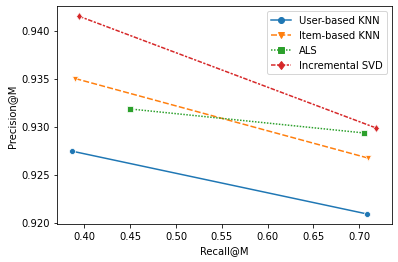

In [ ]:
p = sns.lineplot(x='Recall@M', y='Precision@M', hue='Algorithm', style='Algorithm', markers=['o','v','s','d'], data=tradeoff_df)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=1)

p.get_figure().savefig('Precision_Recall_Tradeoff.png', dpi=1000)